In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [2]:
# Load the data
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']
ais = pd.read_csv('rotterdam_hamburg.arff', names = names, skiprows = 27, parse_dates = True, index_col = 'ID',
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [3]:
ais.head()

,TripID,MMSI,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,StartPort,EndPort,...,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Name,Callsign,AisSourcen
ID,,,,,,,,,,,,,,,,,,,,,
39110154,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.82,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
39112959,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.83,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
39118599,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.83,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
39123728,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.84,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
39127583,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.85,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a


In [4]:
ais_nan = ais

In [5]:
# Convert time columns to correct dtype
ais_nan['StartTime'] = pd.to_datetime(ais_nan['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['EndTime'] = pd.to_datetime(ais_nan['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['time'] = pd.to_datetime(ais_nan['time'], format = '\'%Y-%m-%d %H:%M\'')

In [6]:
# Convert all headings that are 511 (>= 360) to NaN
ais_nan.loc[ais_nan['TH'] >= 360, 'TH'] = np.nan

In [7]:
# Convert courses >= 360 to NaN
ais_nan.loc[ais_nan['COG'] >= 360, 'COG'] = np.nan

In [8]:
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais_nan.loc[(ais_nan['shiptype'] == '0') | (ais_nan['shiptype'] == '159'), 'shiptype'] = np.nan

In [9]:
# Set invalid lengths (0 or > 400) to NaN
ais_nan.loc[(ais_nan['Length'] <= 0) | (ais_nan['Length'] > 400), 'Length'] = np.nan

In [10]:
# Set invalid lengths (0 or > 59) to NaN
ais_nan.loc[(ais_nan['Breadth'] <= 0) | (ais_nan['Breadth'] > 59), 'Breadth'] = np.nan

In [11]:
# Set speeds that are unrealisticly high to NaN
ais_nan.loc[ais_nan['SOG'] > 25.6, 'SOG'] = np.nan

In [12]:
ais_dropped = ais_nan.drop(['AisSourcen', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)

In [13]:
ais_dropped.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Callsign
ID,,,,,,,,,,,,,,,,,,
39110154,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:04:00,269.0,32.0,10.64,53.95,7.82,14.7,81.0,80.0,HAMBURG,5BND2
39112959,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:05:00,269.0,32.0,10.64,53.95,7.83,14.7,80.0,80.0,HAMBURG,5BND2
39118599,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:06:00,269.0,32.0,10.64,53.95,7.83,14.7,81.0,80.0,HAMBURG,5BND2
39123728,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:07:00,269.0,32.0,10.64,53.95,7.84,14.7,80.0,80.0,HAMBURG,5BND2
39127583,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:08:00,269.0,32.0,10.64,53.95,7.85,14.7,81.0,80.0,HAMBURG,5BND2


Text(0.5,1,u'All Positions Before Filtering')

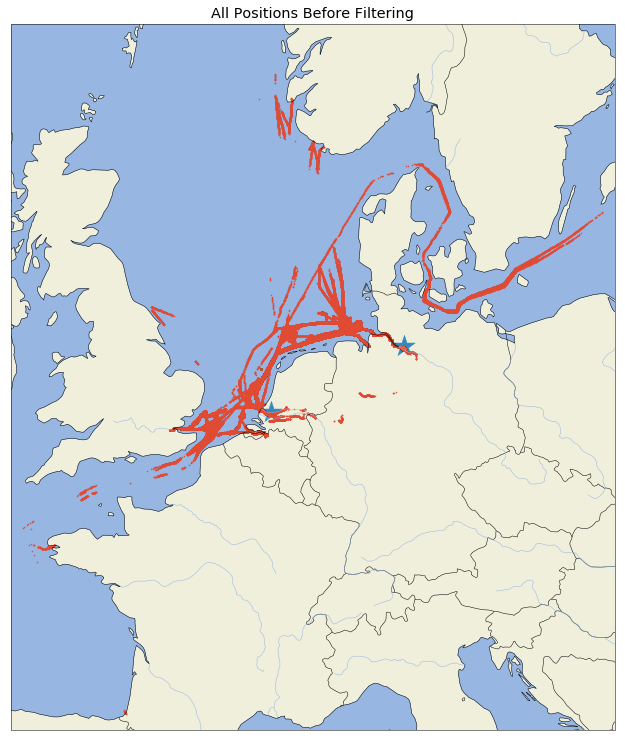

In [14]:
# Plot all positions in the data before any filters are applied
aismap.plot_to_map(size = (13, 13), longitude = ais_dropped['Longitude'], latitude = ais_dropped['Latitude'])
plt.title("All Positions Before Filtering")

Text(0.5,1,u'Start Positions Before Filtering')

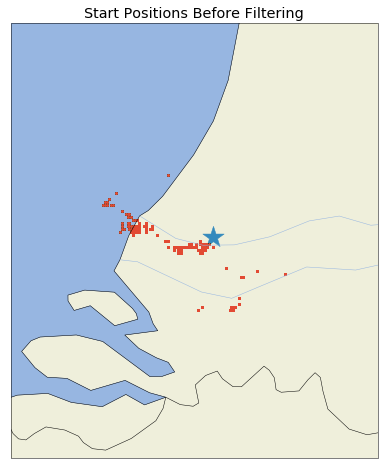

In [15]:
# Plot start positions before any filtering to map
aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['StartLongitude'], latitude = ais_dropped['StartLatitude'])
plt.title("Start Positions Before Filtering")

Text(0.5,1,u'End Positions Before Filtering')

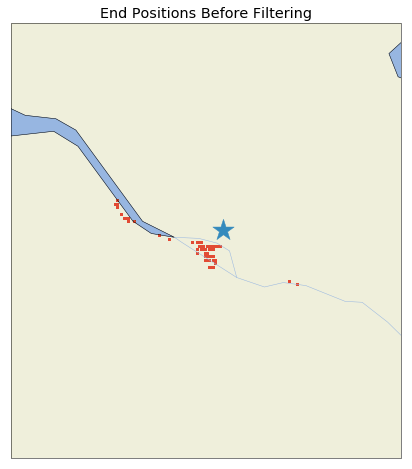

In [16]:
# Plot end positions before any filtering to map
aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['EndLongitude'], latitude = ais_dropped['EndLatitude'])
plt.title("End Positions Before Filtering")

In [17]:
# Get rid of trips that leave our zone (2.45 - 10.66 / 51.49 - 55.06)

outside_long_mask = (ais_dropped['Longitude'] < 2.45) | (ais_dropped['Longitude'] > 10.66)
outside_lat_mask = (ais_dropped['Latitude'] < 51.49) | (ais_dropped['Latitude'] > 55.06)

outside_rec_mask = outside_long_mask | outside_lat_mask

outside_trip_ids = ais_dropped['TripID'][outside_rec_mask].unique()
outside_trip_mask = ~ais_dropped['TripID'].isin(outside_trip_ids)
ais_zoned = ais_dropped[outside_trip_mask]

Text(0.5,1,u'All Positions After Filtering to Our Zone')

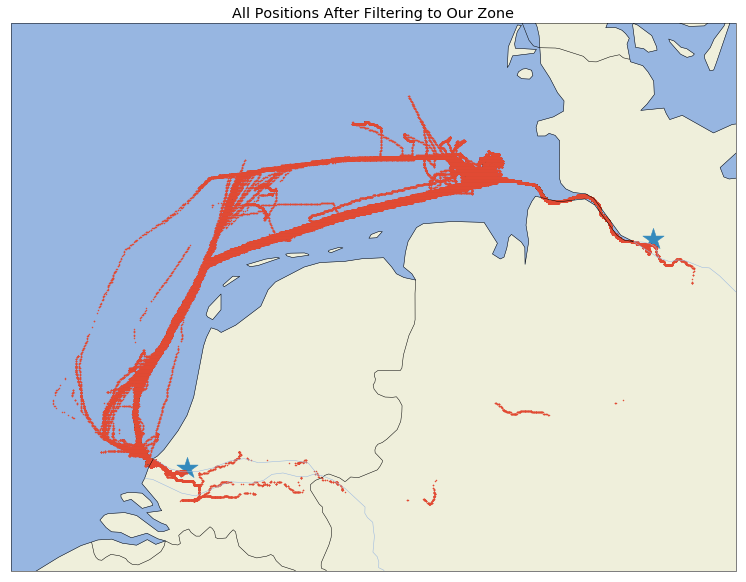

In [18]:
aismap.plot_to_map(size = (13, 13), longitude = ais_zoned['Longitude'], latitude = ais_zoned['Latitude'])
plt.title("All Positions After Filtering to Our Zone")

In [19]:
ais_tts = ais_zoned
ais_tts.is_copy = False   # Silence SettingWithCopyWarning

# Add time for the entire trip to the data
ais_tts['TravelTime'] = ais_tts['EndTime'] - ais_tts['StartTime']
ais_tts['TravelTimeMins'] = ais_tts['TravelTime'].transform(lambda x : x.total_seconds() / 60)

# Add time remaining until arrival at destination
ais_tts['remainingTT'] = ais_tts['EndTime'] - ais_tts['time']
ais_tts['remainingMins'] = ais_tts['remainingTT'].transform(lambda x : x.total_seconds() / 60)

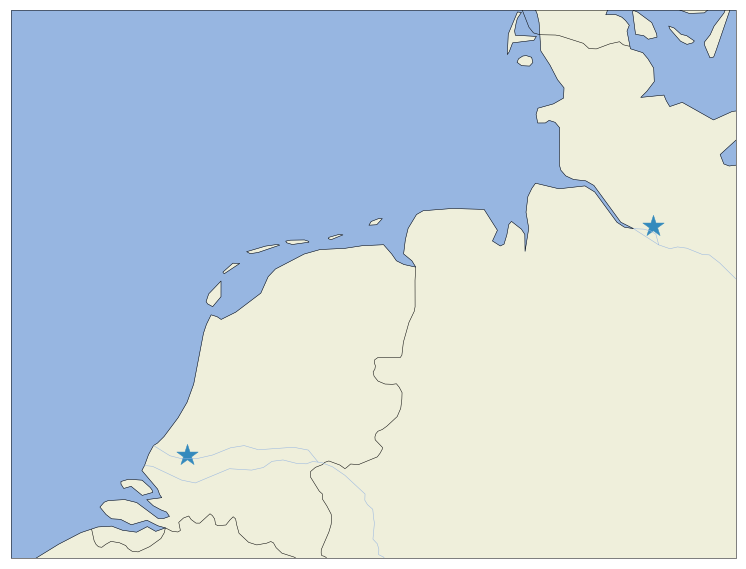

In [20]:
aismap.plot_trips(ais_tts, 'TravelTime')

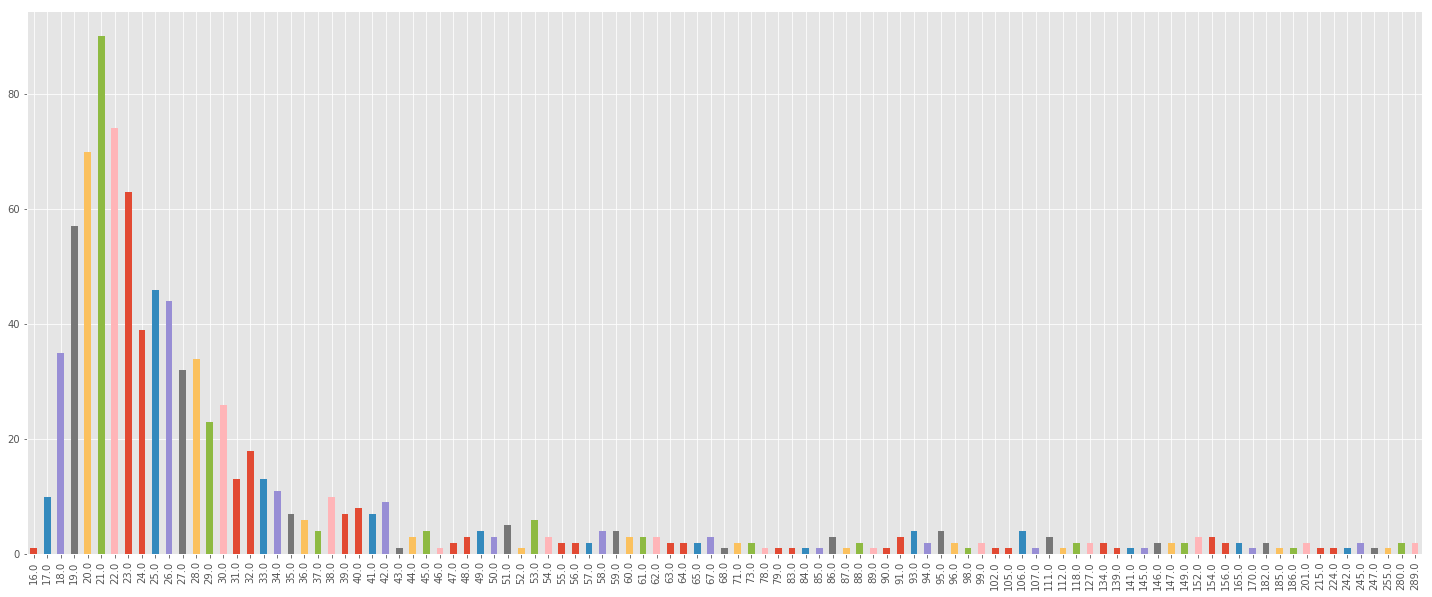

In [21]:
travel_times = ais_tts.groupby('TripID')['TravelTime'].max()
travel_times = travel_times.transform(lambda x : x.total_seconds() // 3600)
travel_times.value_counts().sort_index().plot.bar(figsize = (25, 10))

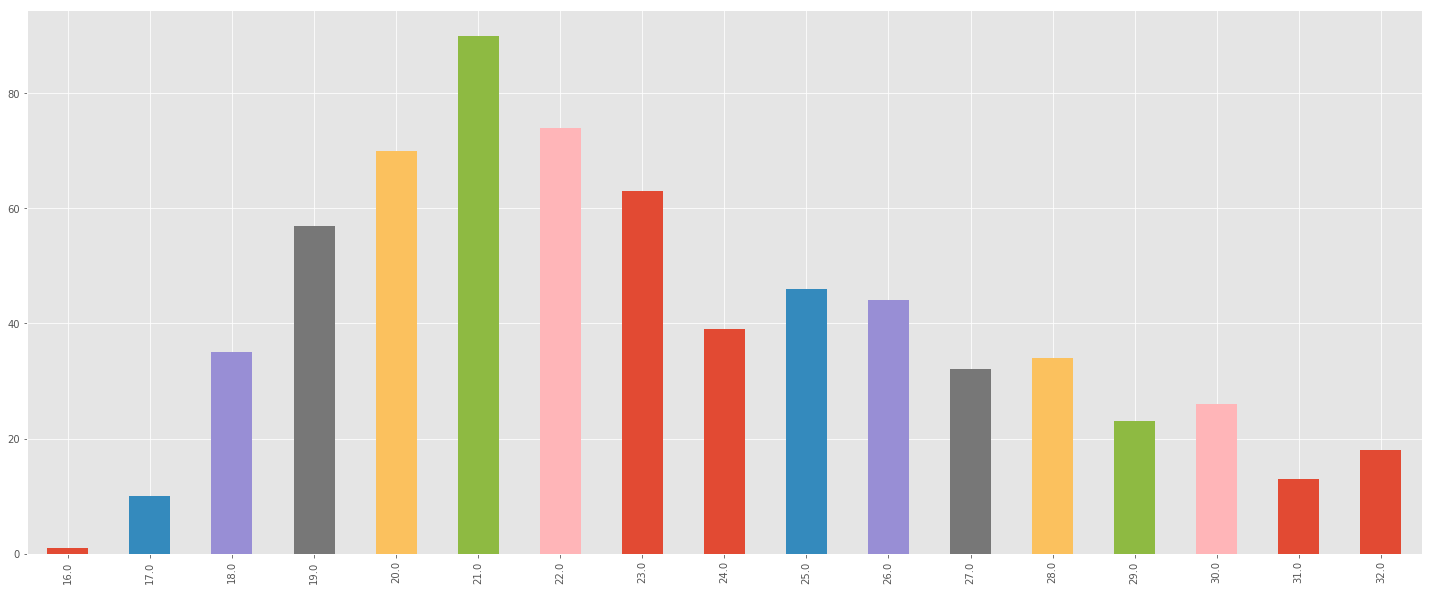

In [22]:
travel_times[travel_times < travel_times.quantile(.75)].value_counts().sort_index().plot.bar(figsize = (25, 10))

In [23]:
# Only keep majority of shorter trips
ais_shortmaj = ais_tts[ais_tts['TravelTime'] < ais_tts['TravelTime'].quantile(.75)]
ais_shortmaj['TravelTime'].describe()

count                    905535
mean     1 days 01:04:52.823336
std      0 days 04:30:03.804882
min             0 days 16:59:00
25%             0 days 21:34:00
50%             1 days 00:10:00
75%             1 days 04:14:00
max             1 days 13:08:00
Name: TravelTime, dtype: object

In [24]:
#ais_shortmaj['Cur_Pos'] = list(zip(ais_shortmaj['Latitude'], ais_shortmaj['Longitude']))
#ais_shortmaj['End_Pos'] = list(zip(ais_shortmaj['EndLatitude'], ais_shortmaj['EndLongitude']))

In [25]:
#ais_shortmaj['Distance'] =  ais_shortmaj.apply(lambda r: pandasVincenty(r), axis=1)
#ais_shortmaj.head()

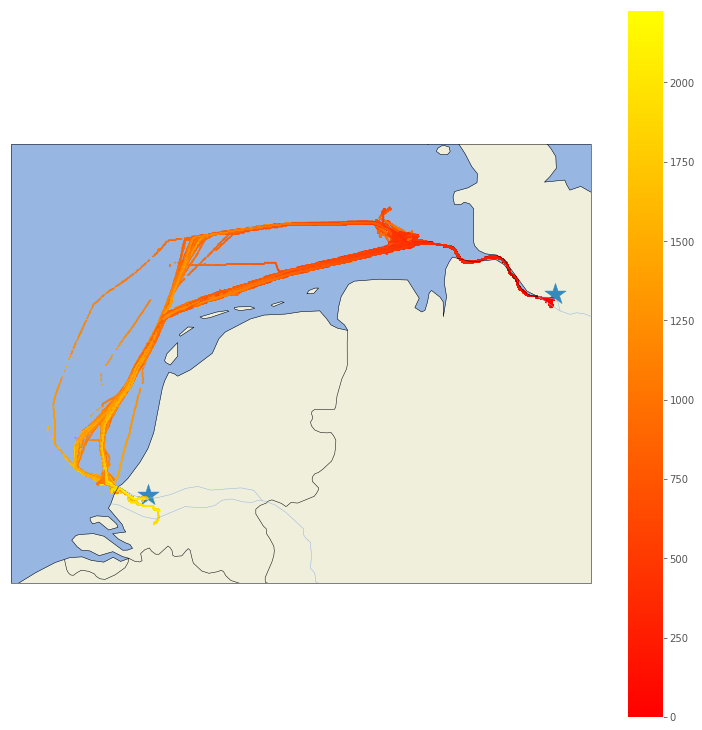

In [26]:
aismap.col_plot_to_map(size = (13, 13), longitude = ais_shortmaj['Longitude'], latitude = ais_shortmaj['Latitude'], col= ais_shortmaj['remainingMins'])

In [27]:
# Get and plot the longest trip in the data set
longest_trip = ais_shortmaj[ais_shortmaj['TravelTime'] == ais_shortmaj['TravelTime'].max()]
longest_trip.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,...,Longitude,SOG,COG,TH,Destination,Callsign,TravelTime,TravelTimeMins,remainingTT,remainingMins
ID,,,,,,,,,,,,,,,,,,,,,
349233224,164547,51.93,4.05,2016-07-05 05:19:00,53.51,9.93,2016-07-06 18:27:00,2016-07-05 08:17:00,291.0,45.0,...,3.87,11.1,346.6,347.0,DE.HAM,3FMZ2,1 days 13:08:00,2228.0,1 days 10:10:00,2050.0
349033601,164547,51.93,4.05,2016-07-05 05:19:00,53.51,9.93,2016-07-06 18:27:00,2016-07-05 06:19:00,291.0,45.0,...,4.08,4.5,23.6,17.0,DE.HAM,3FMZ2,1 days 13:08:00,2228.0,1 days 12:08:00,2168.0
349302261,164547,51.93,4.05,2016-07-05 05:19:00,53.51,9.93,2016-07-06 18:27:00,2016-07-05 08:57:00,291.0,45.0,...,3.86,10.7,5.9,6.0,DE.HAM,3FMZ2,1 days 13:08:00,2228.0,1 days 09:30:00,2010.0
349334478,164547,51.93,4.05,2016-07-05 05:19:00,53.51,9.93,2016-07-06 18:27:00,2016-07-05 09:15:00,291.0,45.0,...,3.87,10.5,6.1,6.0,DE.HAM,3FMZ2,1 days 13:08:00,2228.0,1 days 09:12:00,1992.0
349363344,164547,51.93,4.05,2016-07-05 05:19:00,53.51,9.93,2016-07-06 18:27:00,2016-07-05 09:31:00,291.0,45.0,...,3.87,10.2,6.0,6.0,DE.HAM,3FMZ2,1 days 13:08:00,2228.0,1 days 08:56:00,1976.0


Text(0.5,1,u'Longest Trip in the Data Set')

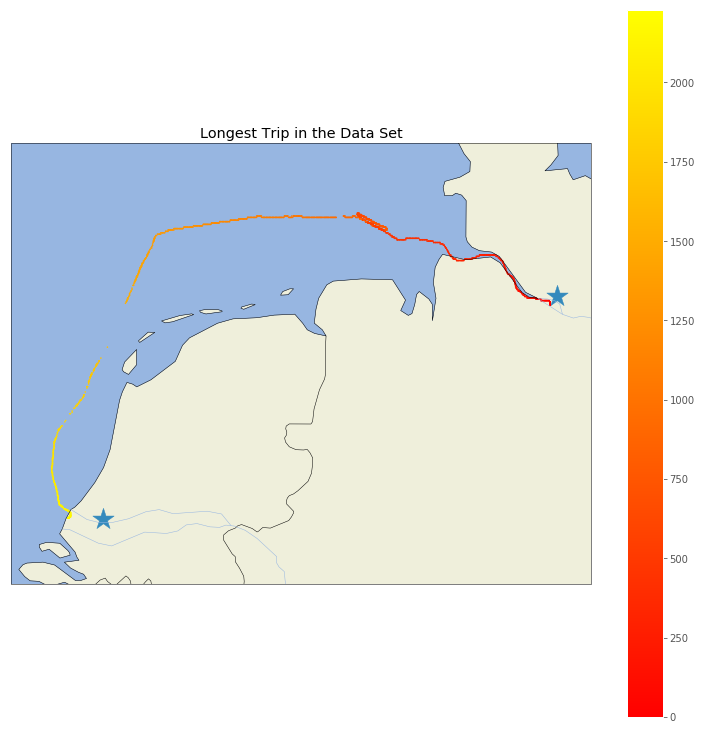

In [28]:
aismap.col_plot_to_map(size = (13, 13), longitude = longest_trip['Longitude'], latitude = longest_trip['Latitude'], col = longest_trip['remainingMins'])
plt.title("Longest Trip in the Data Set")

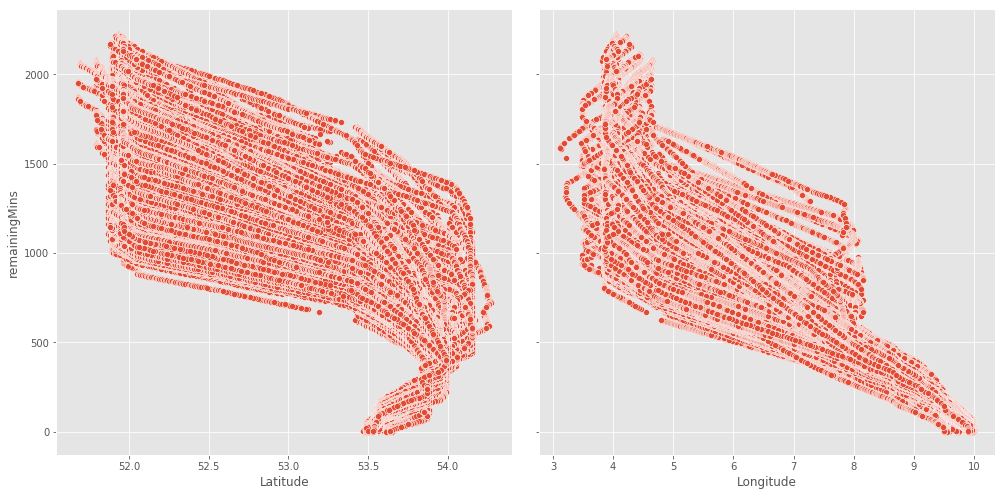

In [29]:
sns.pairplot(ais_shortmaj, x_vars = ['Latitude', 'Longitude'], y_vars = 'remainingMins', size = 7)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

In [ ]:
X = ais_shortmaj[['Latitude', 'Longitude']]
y = ais_shortmaj['remainingTT']
y = y.transform(lambda x : x.total_seconds() / 60)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1)

In [ ]:
lin = LinearRegression()
lin.fit(X_train, y_train)

In [ ]:
lin_pred = lin.predict(X_test)
sqrt(metrics.mean_squared_error(y_test, lin_pred))

In [ ]:
knn = KNeighborsRegressor(n_neighbors = 100)
knn.fit(X_train, y_train)

In [ ]:
knn_pred = knn.predict(X_test)
sqrt(metrics.mean_squared_error(y_test, knn_pred))

In [ ]:
import math

k_range = range(1, 30)
scores = []

for k in k_range :
    kknn = KNeighborsRegressor(n_neighbors = k)
    kknn.fit(X_train, y_train)
    kknn_pred = kknn.predict(X_test)
    scores.append(sqrt(metrics.mean_squared_error(y_test, kknn_pred)))

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(k_range, scores)